In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Import common Python libraries

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common import plot_data
from matplotlib.pyplot import cm

matplotlib.rc("figure", figsize=(8, 6))

colors = cm.tab10(np.linspace(0, 1, 10))

## Load example data

In [3]:
df = pd.read_csv("data/aircraft.csv", index_col=0)

train_acs = "A320,A343,A359,A388,B737,B744,B748,B752,B763,B773,B789,C550,E145,E190"
train_acs = train_acs.split(",")

df_train = df.query("index in @train_acs")
df_test = df.query("index not in @train_acs")

x = df.max_weight.values
y = df.max_thrust.values

x_train = df_train.max_weight.values
y_train = df_train.max_thrust.values

x_test = df_test.max_weight.values
y_test = df_test.max_thrust.values

## Linear regression
First, let's apply the simple linear regression with the training data.

In [4]:
b1, b0 = np.polyfit(x_train, y_train, deg=1)

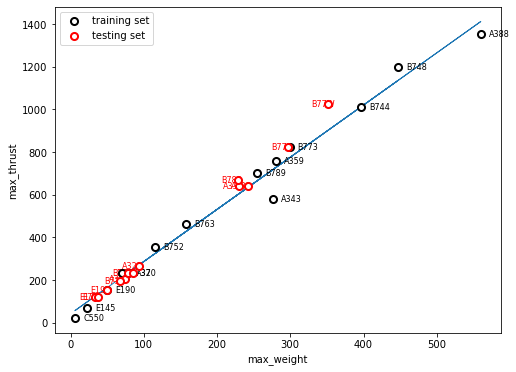

In [5]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="max_weight", ycol="max_thrust", show_test=True, show_type=True)
ax.plot(x_train, b0 + b1 * x_train, lw=1)
plt.show()

### 🤔🤔 Is this the only model that can represent our data?

###  How about the following ones?

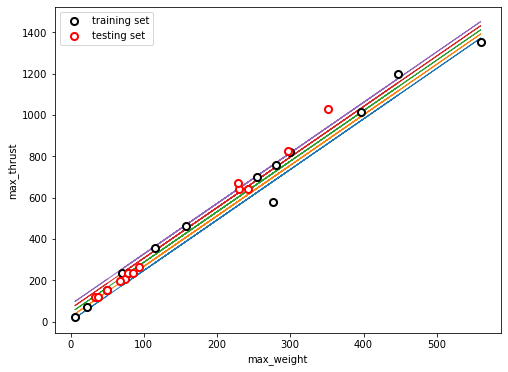

In [6]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="max_weight", ycol="max_thrust", show_test=True)
for eps in np.linspace(-40, 40, 5):
    ax.plot(x_train, b0 + eps + b1 * x_train, lw=1)
plt.show()

Even though the first line fits the best in terms of RMSE. We can see that other lines in the figure above can also represent the data to a certain degree.

In fact, there might exist a set of probability density functions that can represent the coefficients of the data.

This is when Bayesian regression can be useful. In stead of produce a single regression model with fixed coefficients. We want to find out what is the **probabilistic distributions of the coefficients**.

# Bayesian linear regression

Let's recall the the linear regression model:

$$
\mathbf{y} = \mathbf{X} \beta + \epsilon
$$

Here, $\beta$ is the coefficient vector and $\epsilon$ is the error term.

In Bayesian linear regression, we express the model as follows:

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{X} \beta, \sigma^2)
$$

Here, we consider the output $\mathbf{y}$ as a random variable, where the data point is distributed according to a Normal distribution. The mean distribution is dependent on the coefficients (random variables) and input. In addition, $\mathbf{y}$ has a standard deviation of $\sigma$, which is also considered as random variables.

<img src="https://i.imgur.com/GDZHjW9.png" style="margin:auto" width=400px/>

These two different ways of describe the model are essentially the same. However, we have a couple of advantage now.

## Advantages of Bayesian estimation

---

### 1. Priors for coefficients
We consider all coefficient as random variables. Commonly, we assume they follows a Normal distribution:

$$
\beta_i \sim \mathcal{N}(\mu_{\beta,i}, \sigma_{\beta,i}^2)
$$

where $\mu_{\beta,i}$ and $\sigma_{\beta,i}^2$ are the mean and variance of the prior distribution.

<br>

### 2. Posterior distributions of the coefficients
Once we solve the equations, instead of having one single estimate of the coefficients $\hat \beta$, we now have the posterior distributions of the coefficients. 

## Solving Bayesian regression

The Bayesian regression problem can be solved with Markov chain Monte Carlo (MCMC) method. The logic works like the following:

1. Chose a sample from the coefficient distribution.
2. Calculate the probability of output.
3. Accept or reject the previous sample based on this probability.
4. If the sample is accepted, update the distribution with the new sample as the mean. If the sample is rejected, maintain the same distribution.
5. Repeat step 1.

After a large number of iterations, we will have a stable distribution which can be considered as the posterior for the coefficients. 

This process is also called Metropolis–Hastings algorithm, which is a simplest form of MCMC method.

For more samplers, you can have a look at the `pymc3` documentation:

https://docs.pymc.io/api/inference.html#step-methods

## Visualize of the MCMC process

Often multiple chains are employed to preform the previous sampling process. This is one way to ensure the convergence of the MCMC process.

<img src="https://revolution-computing.typepad.com/.a/6a010534b1db25970b019aff4a7bbc970d-800wi" style="margin:auto" />

Image source: https://blog.revolutionanalytics.com/2013/09/an-animated-peek-into-the-workings-of-bayesian-statistics.html

## Implementation

In this demonstration, we are using `pymc3` to solve our regression problem

<img src="https://i.imgur.com/GDZHjW9.png" style="margin:auto" width=350px/>

In [7]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sd=20)
    beta_1 = pm.Normal("beta_1", mu=0, sd=20)
    sigma = pm.HalfNormal("sigma", sd=30)

    y = pm.Normal("y", mu=beta_0 + beta_1 * x_train, sd=sigma, observed=y_train)

    # using the simplest MH sampler
    step = pm.Metropolis()
    
    # we are drawing 5000 samples using 4 chains
    trace = pm.sample(draws=5000, step=step, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_1]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The number of effective samples is smaller than 10% for some parameters.


<Figure size 504x504 with 0 Axes>

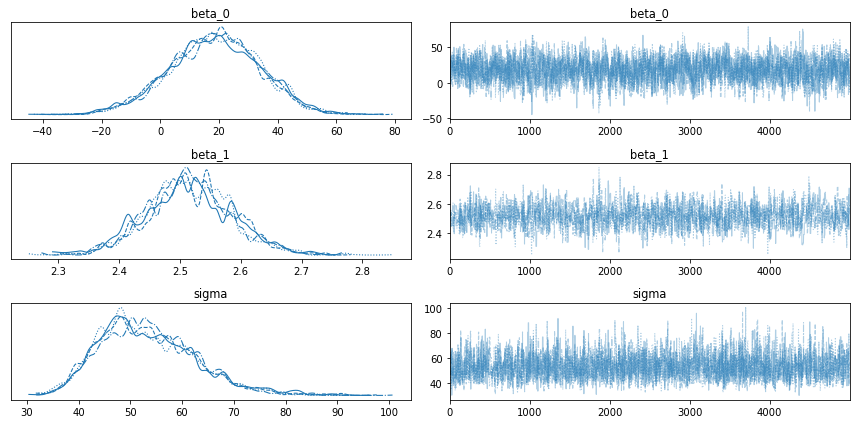

In [9]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()
plt.show()

## Drawing regressors from posterior distributions

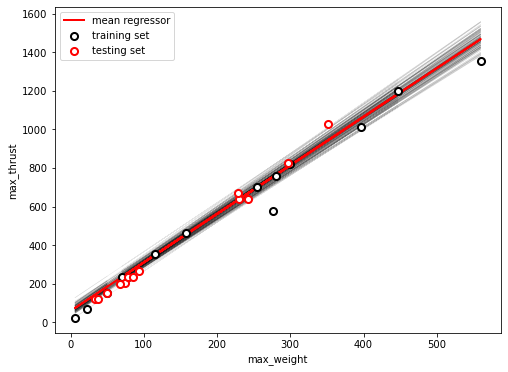

In [10]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="max_weight", ycol="max_thrust", show_test=True)

for i in range(100):
    b0 = np.random.choice(trace["beta_0"])
    b1 = np.random.choice(trace["beta_1"])
    ax.plot(x_train, b0 + eps + b1 * x_train, lw=0.5, color="k", alpha=0.1)

b0 = trace["beta_0"].mean()
b1 = trace["beta_1"].mean()
ax.plot(x_train, b0 + eps + b1 * x_train, lw=2, color="r", label="mean regressor")

plt.legend()

plt.show()

## Visualize the MCMC chain

In [11]:
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(4):
    ax = axes.flatten()[i]
    ax.set_xlim(-60, 100)
    ax.set_ylim(2.2, 2.9)
    ax.set_title("chain {}".format(i+1))
    ax.set_xlabel('$\\beta_0$')
    ax.set_ylabel('$\\beta_1$')
plt.tight_layout()

line0, = axes[0][0].plot([], [], lw=0.2, color=colors[0])
line1, = axes[0][1].plot([], [], lw=0.2, color=colors[1])
line2, = axes[1][0].plot([], [], lw=0.2, color=colors[2])
line3, = axes[1][1].plot([], [], lw=0.2, color=colors[3])


def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line0, line1, line2, line3


def animate(i):
    for c, l in enumerate([line0, line1, line2, line3]):
        b0 = trace.get_values(chains=c, varname="beta_0")[: i * 20]
        b1 = trace.get_values(chains=c, varname="beta_1")[: i * 20]
        l.set_data(b0, b1)

    return line0, line1, line2, line3


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=250, interval=20, blit=True)

plt.close(anim._fig)

In [12]:
HTML(anim.to_html5_video())